## Библиотеки и определение функций

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import random as rm
import numpy as np
import pandas as pd
from numpy.random import default_rng
import time
from functools import lru_cache

rng = default_rng()

In [3]:
def str2int_arr(str):
    return [float(i) for i in str]

def graph_from_file(file):
    w = []
    with open(file, "r") as f:
        for line in f:
            arr = line.split()
            map(int, arr)
            w.append(str2int_arr(arr))
    return nx.from_numpy_matrix(np.array(w))

def graph_from_dimacs(file):
    G = nx.Graph()
    with open(file, "r") as f:
        for line in f:
            buff = line.split()
            if buff[0]=="p":
                G.add_nodes_from([i for i in range(1, int(buff[2])+1 )])
                break
        for line in f:
            edge = line.split()
            G.add_edge(int(edge[1]), int(edge[2]))
    return G

In [4]:
def digits_from_01(arr):
    digits = []
    for i in range(len(arr)):
        if int(arr[i]) == 1:
            digits.append(i) 
    return digits
    

def initial_population(n, size):
    population = []
    for _ in range(size):
        individual = ""
        for _ in range(n):
            individual += rm.choice("0")
        population.append(individual)
    return population
    
@lru_cache(maxsize=None)
def adaptability(individual, B=2):
    subgraph_v = np.array([], dtype="int")
    
    for i in range(G.number_of_nodes()):
        if individual[i]==1:
            subgraph_v = np.append(subgraph_v, [i])
            
    subgraph = nx.subgraph(G, list(subgraph_v))
    n = subgraph_v.size
    return max((-n*(n-1)//2 + subgraph.number_of_edges()) * B + n, 1) #max(n-(n*(n-1)//2 + subgraph.number_of_edges())*fine, 1)

def roulette(population, k):
    
    population_weights = [adaptability(G, i) for i in population]
    #if sum(population_weights)==0 :
    #    population_weights = [1 for _ in range(len(population_weights))]
    descendants = rm.choices(population, population_weights, k=k)
    
    return descendants

def crossover(parents):
    point = rm.randint(0, parents[0].size)
    child = np.concatenate((parents[0][:point], parents[1][point:]))
    return child 

def mutation(individual, probability = 0.5):
    if rm.random()>probability:
        return individual
    
    point = rm.randint(0, individual.size-1)
    
    individual[point] ^= 1
    
    return individual

def multy_mutation(individual):
    num_mutation=5
    n = individual.size
    for i in range(num_mutation):
        individual[np.random.randint(0, n)] ^= 1
    
    return individual

def print_p(population):
    for i in population:
        for j in i:
            print(j, end='')
        print()


def GA( p_size = 40,
        np_size = 40,
        max_iteration = 1500,
        elite_size = 5,
        tour_size = 5,
        unchanged_threshold=20,):
    
    population = np.zeros((p_size, G.number_of_nodes()), dtype="byte")  # np.array(initial_population(n, p_size), dtype="str")
    population = np.array(list(map(multy_mutation, population)), dtype="byte")
    p_adaptability = np.array([adaptability(tuple(ind)) for ind in population], dtype="int")

    new_population = np.zeros((np_size, G.number_of_nodes()), dtype="byte")
    new_p_adaptability = np.zeros(np_size, dtype="int")

    unchanged_count = 0
    best_solution = p_adaptability[0]
    iter = 0
    
    for _ in range(max_iteration):
        iter += 1
        # выбор родителей + скрещивание + мутация
        for i in range(np_size):
            
            new_population[i] = mutation(crossover( rm.choices(population, p_adaptability, k=2) ), probability=0.6 )#  ???
            new_p_adaptability[i] = adaptability(tuple(new_population[i]))

        # объединение популяций
        new_population = np.concatenate((population, new_population[:np_size]))
        new_p_adaptability = np.concatenate((p_adaptability, new_p_adaptability[:np_size]))
        
        # выбор новой популяции
        new_num = rm.choices(np.arange(p_size + np_size), new_p_adaptability, k=p_size)  # the numbers of individuals for the new population
        # турнирный отбор
        tour_index = []
        for i in range(tour_size):
            tournament = rm.sample(range(p_size+np_size), tour_size)
            tour_max = 0
            tour_max_id = 0
            for j in tournament:
                if(new_p_adaptability[j] > tour_max):
                    tour_max = new_p_adaptability[j]
                    tour_max_id = j
            if(tour_max_id==0):
                tour_max_id = tournament[0]    
            tour_index.append(tour_max_id)
        # выбор самых приспособленных
        elite_index = np.argpartition(-new_p_adaptability, elite_size)
        
        for i in range(elite_size):
            population[i] = new_population[elite_index[i]]
            p_adaptability[i] = new_p_adaptability[elite_index[i]]
        for i in range(elite_size, tour_size):
            population[i] = new_population[tour_index[i]]
            p_adaptability[i] = new_p_adaptability[tour_index[i]]
        for i in range(elite_size+tour_size, p_size):
            population[i] = new_population[new_num[i]]
            p_adaptability[i] = new_p_adaptability[new_num[i]]
            
        if best_solution == p_adaptability[0]:
            unchanged_count += 1
            if unchanged_count >= unchanged_threshold:
                break
        else:
            best_solution = p_adaptability[0]
            unchanged_count = 0
        
    return p_adaptability, population#, iter

## Загрузка графа  и работа алгоритма

In [4]:
G = graph_from_file("data/graph_examples/34_14")
#----------Hyperparameters----------
p_size = 20
np_size = 20
iterations = 1000
elite_size = 3
#-----------#-----------#----------- 

p_adaptability, population = GA(p_size, np_size, iterations, elite_size)
        
print(p_adaptability)
iter
#print_p(population)

[12 12 12 12 11  3  5  3 11  8 11 12 12 12 12 11 12 11  9 12]


<function iter>

## Таблица с результатами тестов

In [5]:
df = pd.DataFrame(columns=['population size', 'new population size', 'number of iterations', 'number of runs', 'best score',"average score" , 'time'])

In [36]:
G = graph_from_dimacs("data/DIMACS_subset_ascii/C125.9.clq")
#----------Hyperparameters----------
p_size = 40
np_size = 50
iterations = 5000
elite_size = 3
number_of_runs = 3
#-----------#-----------#----------- 

In [37]:
def mult_GA(num_parameter, arr,  p_size, np_size, iterations, number_of_runs, df):
    for i in arr:
        
        start_time = time.time()
        input = [p_size, np_size, iterations, number_of_runs]
        input[num_parameter] = i 
        result = 0
        avg = 0
        
        for _ in range(input[3]):
            p_adaptability, population = GA(*input[:3], elite_size)
            avg += p_adaptability[0]
            result = max(result, p_adaptability[0])        

        avg = avg / input[3]
        df.loc[len(df)] = [*input, result, avg, (time.time() - start_time)]

In [38]:
pop_sizes =  [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]
mult_GA(0, pop_sizes, p_size, np_size, iterations, number_of_runs, df)

In [39]:
np_sizes =  [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]
mult_GA(1, np_sizes, p_size, np_size, iterations, number_of_runs, df)

In [40]:
iterations_arr = [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000, 2500, 3000, 4000, 5000, 7500, 10000]
mult_GA(2, iterations_arr, p_size, np_size, iterations, number_of_runs, df)

In [13]:
numbers_of_runs_arr = [1, 2, 5, 10, 15, 25]
mult_GA(3, numbers_of_runs_arr, p_size, np_size, iterations, number_of_runs, df)

In [41]:
adaptability.cache_clear()

In [59]:
df[44:]

,population size,new population size,number of iterations,number of runs,best score,average score,time
44,10.0,50.0,5000.0,3.0,27.0,25.000000,4.315909
45,15.0,50.0,5000.0,3.0,28.0,26.000000,5.728716
46,20.0,50.0,5000.0,3.0,27.0,26.000000,8.079830
47,25.0,50.0,5000.0,3.0,30.0,26.666667,14.182828
48,30.0,50.0,5000.0,3.0,28.0,27.000000,17.468370
49,35.0,50.0,5000.0,3.0,26.0,25.000000,14.011868
50,40.0,50.0,5000.0,3.0,28.0,27.000000,11.112436
51,45.0,50.0,5000.0,3.0,28.0,27.000000,9.972530
52,50.0,50.0,5000.0,3.0,26.0,25.333333,8.891558
53,60.0,50.0,5000.0,3.0,29.0,26.333333,8.956607


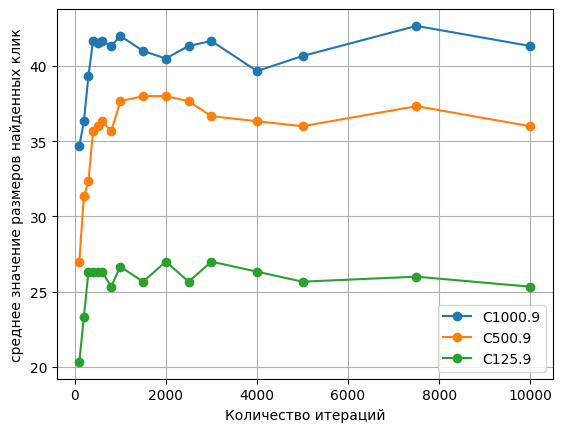

In [109]:
df_xl = pd.read_excel("data.xlsx", sheet_name='3')
df_x2 = pd.read_excel("data.xlsx", sheet_name='6')
df_x3 = pd.read_excel("data.xlsx", sheet_name='9')

plt.plot(df_xl['number of iterations'], df_xl['average score'], marker='o', label="C1000.9")  
plt.plot(df_x2['number of iterations'], df_x2['average score'], marker='o', label="C500.9")
plt.plot(df_x3['number of iterations'], df_x3['average score'], marker='o', label="C125.9")
#plt.title('Выручка компании по годам')  # Заголовок графика
plt.xlabel('Количество итераций')  

plt.ylabel('среднее значение размеров найденных клик')  

plt.grid(True)  
plt.legend()
plt.show() 

## Проверка на графах из DIMACS

In [2]:
DIMACS = ["C125.9",
        "C250.9",
        "C500.9",
        "C1000.9",
        "C2000.9",
        #"DSJC1000_5",
        #"DSJC500_5",
        "C2000.5",
        "C4000.5",
        "MANN_a27",
        "MANN_a45",
        #"MANN_a81",
        "brock200_2",
        "brock200_4",
        "brock400_2",
        "brock400_4",
        "brock800_2",
        "brock800_4",
        "gen200_p0.9_44",
        "gen200_p0.9_55",
        "gen400_p0.9_55",
        "gen400_p0.9_65",
        "gen400_p0.9_75",
        "hamming10-4",
        "hamming8-4",
        "keller4",
        "keller5",
        #"keller6",
        "p_hat300-1",
        "p_hat300-2",
        "p_hat300-3",
        "p_hat700-1",
        "p_hat700-2",
        "p_hat700-3",
        "p_hat1500-1",
        "p_hat1500-2",
        "p_hat1500-3"]

In [19]:
df_dim = pd.DataFrame(columns=["Benchmark", "GA 𝝎(G)", "GA Time [s]"])

In [20]:
import pickle
for graph_number in range(len(DIMACS)):
    G = graph_from_dimacs("data/DIMACS_subset_ascii/"+ DIMACS[graph_number] +".clq")
    start_time = time.time()
    p_adaptability, population = GA(p_size, np_size, 1000, elite_size, unchanged_threshold=20)
    
    df_dim.loc[len(df_dim)] = [DIMACS[graph_number], max(p_adaptability), (time.time() - start_time)]
    
    adaptability.cache_clear()
    with open('data/graphFromGaToHop/'+ DIMACS[graph_number] +'.pkl', 'wb') as out:
        pickle.dump(population, out, 2)
        
    print(graph_number, " done", end='\n')

0  done
1  done
2  done
3  done
4  done
5  done
6  done
7  done
8  done
9  done
10  done
11  done
12  done
13  done
14  done
15  done
16  done
17  done
18  done
19  done
20  done
21  done
22  done
23  done
24  done
25  done
26  done
27  done
28  done
29  done
30  done
31  done
32  done


In [21]:
df_dim

,Benchmark,GA 𝝎(G),GA Time [s]
0,C125.9,25,2.773491
1,C250.9,33,10.008866
2,C500.9,32,13.775530
3,C1000.9,45,71.743308
4,C2000.9,46,132.309413
5,C2000.5,10,11.026747
6,C4000.5,11,41.233871
7,MANN_a27,118,122.379655
8,MANN_a45,328,2108.512441
9,brock200_2,7,0.538621


## Генерация популяции для сети Хопфилда

In [13]:
p_adaptability, population = GA(p_size, np_size, iterations, elite_size)

In [14]:
p_adaptability

array([26, 26, 26, 26, 26,  1,  3,  3,  5,  1, 17, 25, 26, 18, 21, 26, 23,
       18, 23, 25, 25,  1, 26, 15, 25, 20, 13, 18, 22, 24, 20, 22, 25, 26,
       19, 21, 25, 17, 26, 24])

In [15]:
population[0]

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0], dtype=int8)

In [16]:
import pickle
with open('data/graphFromGaToHop/g'+str(G.number_of_nodes())+"_"+str(p_adaptability[0])+'.pkl', 'wb') as out:
    pickle.dump(population, out, 2)

In [1]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir("data/graphFromGaToHop") if isfile(join("data/graphFromGaToHop", f))]
onlyfiles

['g1000_42.pkl',
 'g1000_45.pkl',
 'g1024_21.pkl',
 'g125_26.pkl',
 'g1500_33.pkl',
 'g1500_42.pkl',
 'g1500_6.pkl',
 'g171_7.pkl',
 'g2000_47.pkl',
 'g2000_9.pkl',
 'g200_12.pkl',
 'g200_28.pkl',
 'g200_30.pkl',
 'g200_7.pkl',
 'g250_33.pkl',
 'g256_10.pkl',
 'g300_17.pkl',
 'g300_25.pkl',
 'g300_7.pkl',
 'g378_117.pkl',
 'g4000_11.pkl',
 'g400_17.pkl',
 'g400_20.pkl',
 'g400_36.pkl',
 'g400_40.pkl',
 'g400_41.pkl',
 'g500_.pkl',
 'g500_40.pkl',
 'g700_27.pkl',
 'g700_38.pkl',
 'g700_6.pkl',
 'g776_15.pkl',
 'g800_13.pkl']